In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
from scipy.stats import pearsonr
import matplotlib
from tqdm import tqdm
from typing import List, Dict
import calpgs
import glob
from natsort import natsorted
import tempfile
import subprocess
from typing import Dict
import itertools
import submitit

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

In [3]:
def plot_figure(
    dict_r2: Dict,
    dict_cov1: Dict,
    dict_cov2: Dict,
    trait: str,
    xlabels: List,
    xlabel_map: Dict,
    ylim_r2: List = None,
    ylim_cov: List = None,
    figsize=None,
):
    """
    Plot the figure for both R2 and coverage

    Parameters
    ----------
    dict_r2: Dict [group -> np.ndarray]
        each group is a R2 matrix [n_seed, n_group] np.ndarray
    dict_cov1: Dict[group -> np.ndarray]
        each group corresponds to a coverage matrix measuring overall calibration
    dict_cov2: Dict[group -> np.ndarray]
        each group corresponds to a coverage matrix measureing by-covariate calibration
    trait: str
        trait

    """
    width_ratios = [dict_r2[x].shape[1] for x in xlabels]
    if figsize is None:
        figsize = (0.3 * sum(width_ratios) + 0.1 * len(width_ratios), 3.5)
        print("Default figsize:", figsize)
    fig, axes = plt.subplots(
        figsize=figsize,
        dpi=150,
        nrows=2,
        ncols=len(xlabels),
        sharex="col",
        sharey="row",
        gridspec_kw={"width_ratios": width_ratios},
    )
    for i, group in enumerate(xlabels):
        ax = axes[0, i]
        df_r2 = dict_r2[group]
        n_group = df_r2.shape[1]
        mean, sd = df_r2.mean(axis=0), df_r2.std(axis=0)
        ax.errorbar(
            x=np.arange(n_group),
            y=mean,
            yerr=sd,
            fmt=".--",
            ms=4,
            mew=1,
            linewidth=1,
            color="black",
        )
        ax.set_xlim(-0.5, n_group - 0.5)
        if ylim_r2 is not None:
            ax.set_ylim(*ylim_r2)
        if i == 0:
            ax.set_ylabel(f"{trait} $R^2$")

    # coverage
    for i, group in enumerate(xlabels):
        ax = axes[1, i]

        ax.axhline(y=0.9, ls="--", lw=1.0, color="black", alpha=0.5)
        if ylim_cov is not None:
            ax.set_ylim(*ylim_cov)
        if i == 0:
            ax.set_ylabel(f"{trait} coverage")

        for cov_i, dict_cov in enumerate([dict_cov1, dict_cov2]):
            cov_vals = dict_cov[group].values
            cov_mean, cov_sd = cov_vals.mean(axis=0), cov_vals.std(axis=0)
            n_group = cov_vals.shape[1]
            label = ["Overall", "By-cov"][cov_i]
            ax.errorbar(
                x=np.arange(n_group) - 0.1 + cov_i * 0.2,
                y=cov_mean,
                yerr=cov_sd,
                fmt=".--",
                ms=4,
                mew=1,
                linewidth=0.8,
                label=label,
            )
        ax.set_xticks(np.arange(n_group))
        ax.set_xlabel(xlabel_map[group])

    return fig, axes

In [4]:
def summarize_result(trait: str, indiv_group: str, method: str, out: str):
    """Summarize calibration results

    Parameters
    ----------
    trait : str
        trait name
    indiv_group : str
        white or other
    method : str
        all or none
    out : str
        output path
    """
    path_list = natsorted(
        glob.glob(f"out/model/{trait}-{indiv_group}/*-{method}.test_info.tsv")
    )
    df_predint = []

    for seed_i, path in enumerate(path_list):
        with tempfile.TemporaryDirectory() as tmp_dir:
            cmds = [
                "calpgs group-r2",
                f"--df {path}",
                "--y pheno --pred cal_pred --predstd cal_predstd",
                "--group PC1,AGE,SEX",
                f"--out {tmp_dir}/out",
                "--n-bootstrap 10 --n-subgroup 5",
            ]
            subprocess.check_call(" ".join(cmds), shell=True)
            df_out = pd.read_csv(f"{tmp_dir}/out.predint.tsv", sep="\t")
            df_out.insert(0, "seed", seed_i)
            df_r2 = pd.read_csv(f"{tmp_dir}/out.r2.tsv", sep="\t")
            df_out["r2"] = df_r2["r2"]
            df_predint.append(df_out)
    pd.concat(df_predint, axis=0).to_csv(out, sep="\t", index=False)

In [4]:
df_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            ["LDL", "height"],
            ["white", "other"],
            ["mean", "mean+var"],
        )
    ],
    columns=[
        "trait",
        "group",
        "method",
    ],
)
df_params["out"] = df_params.apply(
    lambda row: f"out/summary/{row.trait}-{row.group}.{row.method}.tsv",
    axis=1,
)

os.makedirs("out/summary/", exist_ok=True)
print(f"{len(df_params)} jobs in total")

executor = submitit.SgeExecutor(folder="./submitit-logs")

executor.update_parameters(
    time_min=10,
    memory_g=16,
    setup=[
        "export PATH=~/project-pasaniuc/software/miniconda3/bin:$PATH",
        "export PATH=~/project-pasaniuc/software/bin:$PATH",
        "export PYTHONNOUSERSITE=True",
    ],
)

jobs = executor.map_array(
    summarize_result,
    df_params.trait,
    df_params.group,
    df_params.method,
    df_params.out,
)

8 jobs in total


In [5]:
trait, indiv_group = "height", "other"
trait, indiv_group = "LDL", "white"
trait, indiv_group = "LDL", "other"

In [6]:
EXPERIMENT_PREFIX = ""
# EXPERIMENT_PREFIX = "OLD-0627"

In [7]:
df_predint_none = pd.read_csv(
    f"out/{EXPERIMENT_PREFIX}/summary/{trait}-{indiv_group}.mean.tsv",
    sep="\t",
)
df_predint_all = pd.read_csv(
    f"out/{EXPERIMENT_PREFIX}/summary/{trait}-{indiv_group}.mean+var.tsv",
    sep="\t",
)

In [8]:
dict_r2 = {
    group: df_predint_all[df_predint_all.group == group].pivot(
        index="seed", columns="subgroup", values="r2"
    )
    for group in df_predint_all.group.unique()
}
dict_cov1 = {
    group: df_predint_none[df_predint_none.group == group].pivot(
        index="seed", columns="subgroup", values="coverage"
    )
    for group in df_predint_none.group.unique()
}
dict_cov2 = {
    group: df_predint_all[df_predint_all.group == group].pivot(
        index="seed", columns="subgroup", values="coverage"
    )
    for group in df_predint_all.group.unique()
}

for g in dict_r2:
    cols = np.arange(1, len(dict_r2[g].columns) + 1).astype(str)
    dict_r2[g].columns = dict_cov1[g].columns = dict_cov2[g].columns = np.arange(
        1, len(dict_r2[g].columns) + 1
    ).astype(str)

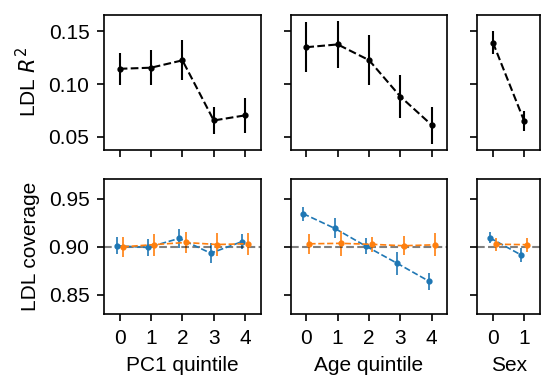

In [9]:
fig, axes = plot_figure(
    dict_r2=dict_r2,
    dict_cov1=dict_cov1,
    dict_cov2=dict_cov2,
    trait=trait,
    xlabels=["PC1", "AGE", "SEX"],
    xlabel_map={
        "pred": "PGS",
        "PC1": "PC1 quintile",
        "AGE": "Age quintile",
        "SEX": "Sex",
    },
    ylim_cov=[0.83, 0.97],
    figsize=(3.8, 2.7),
)
fig.tight_layout()
# fig.savefig(f"results/{trait}-{indiv_group}.pdf", bbox_inches="tight")